In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing

import PIL
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
import numpy as np
# from keras.applications.resnet50 import ResNet50
# from keras.applications import resnet50

In [ ]:
 #make kaggle directory
!mkdir ~/.kaggle

# move kaggle.json to hidden kaggle folder
!cp kaggle.json ~/.kaggle/

# change permissions on file
!chmod 600 ~/.kaggle/kaggle.json

# download zipped data
!kaggle datasets download -d darshan1504/car-body-style-dataset

In [ ]:
!unzip -qq car-body-style-dataset

In [5]:
image_paths = ['/content/CarBodyStyles/Buggy', '/content/CarBodyStyles/Convertible', '/content/CarBodyStyles/Coupe',
               '/content/CarBodyStyles/Hatchback','/content/CarBodyStyles/Limousine','/content/CarBodyStyles/Minivan',
               '/content/CarBodyStyles/Sedan']

In [ ]:
# found invalid files during training, so this removes them
import os
import tensorflow as tf

def is_valid_jpeg(file_path):
    try:
        tf.io.decode_image(tf.io.read_file(file_path))
        return True
    except tf.errors.InvalidArgumentError:
        return False

def remove_invalid_jpeg_files(directory_path):
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if os.path.isfile(file_path) and not is_valid_jpeg(file_path):
            os.remove(file_path)
            print(f"Removed invalid JPEG file: {file_path}")

# Specify the directory path containing the JPEG files
directory_path = '/content/CarBodyStyles'

# Call the function to remove invalid JPEG files
for directory_path in image_paths:
  remove_invalid_jpeg_files(directory_path)

In [16]:
batch_size = 32
image_width = 224
image_height = 224
epochs = 50

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "./CarBodyStyles",
    labels = "inferred",
    validation_split=0.3,
    image_size = (image_height, image_width),
    subset="both",
    seed=542,
    batch_size=batch_size,
)
class_names = train_ds.class_names

Found 3038 files belonging to 7 classes.
Using 2127 files for training.
Using 911 files for validation.


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)# early stopping

In [ ]:
model2 = tf.keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False, # only including the convolution and pooling layers, not the dense FF layers
    input_shape = (image_width, image_height,3)
)

model2.trainable = False
model2.summary()

In [49]:
inputs = kb.Input(shape=(image_width, image_height, 3)) # 3 channels = RGB image
x = kb.applications.vgg16.preprocess_input(inputs)
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomRotation(0.06),  # Randomly rotate the image by up to 6 degrees
    preprocessing.RandomZoom(0.05),  # Randomly zoom into the image by up to 5%
])

x = data_augmentation(inputs)
x = model2(x) # sending images through the pre-trained network
x = kb.layers.Flatten()(x)
x = kb.layers.Dense(1001, kernel_regularizer = "l1")(x)
x = kb.layers.Dropout(0.3)(x)
x = kb.layers.Dense(600, kernel_regularizer = "l1")(x)
x = kb.layers.Dropout(0.5)(x)
x = kb.layers.Dense(255)(x)
# x = kb.layers.Dropout(0.5)(x)
x = kb.layers.Dense(50, kernel_regularizer = "l1")(x)
outputs = kb.layers.Dense(7, activation="softmax")(x)

custom_ff = kb.Model(inputs, outputs)
custom_ff.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [50]:
history2 = custom_ff.fit(
  train_ds,
  validation_data= val_ds,
  epochs=epochs,
  callbacks = [callback], # for regularization
  initial_epoch = 0
  )

Epoch 1/50
67/67 [==============================] - 13s 144ms/step - loss: 1966.7029 - accuracy: 0.3968 - val_loss: 1533.0576 - val_accuracy: 0.5247
Epoch 2/50
67/67 [==============================] - 11s 143ms/step - loss: 1298.7666 - accuracy: 0.5214 - val_loss: 1135.8019 - val_accuracy: 0.5368
Epoch 3/50
67/67 [==============================] - 11s 143ms/step - loss: 935.5381 - accuracy: 0.5778 - val_loss: 814.1979 - val_accuracy: 0.5873
Epoch 4/50
67/67 [==============================] - 11s 143ms/step - loss: 680.6548 - accuracy: 0.6380 - val_loss: 603.0124 - val_accuracy: 0.6389
Epoch 5/50
67/67 [==============================] - 11s 141ms/step - loss: 499.0387 - accuracy: 0.6709 - val_loss: 472.8354 - val_accuracy: 0.5609
Epoch 6/50
67/67 [==============================] - 11s 141ms/step - loss: 422.1513 - accuracy: 0.6197 - val_loss: 396.9425 - val_accuracy: 0.5477
Epoch 7/50
67/67 [==============================] - 11s 142ms/step - loss: 344.4843 - accuracy: 0.6004 - val_loss:

In [ ]:
custom_ff.summary()

Using the subclass way:

In [ ]:
# class CustomFFModel(tf.keras.Model):
#     def __init__(self, image_width, image_height):
#         super(CustomFFModel, self).__init__()

#         # Define data augmentation layers
#         self.data_augmentation = kb.Sequential([
#             preprocessing.Rescaling(1./255),  # Rescale pixel values to [0,1]
#             preprocessing.RandomRotation(0.2),  # Randomly rotate the image by up to 20 degrees
#             preprocessing.RandomZoom(0.2),  # Randomly zoom into the image by up to 20%
#         ])

#         # Define the rest of the layers
#         self.layer1 = kb.applications.VGG16(weights='imagenet', include_top=False)
#         self.flatten = kb.layers.Flatten()
#         self.dense1 = Dense(500)
#         self.dropout1 = kb.layers.Dropout(0.5)
#         self.dense2 = Dense(400)
#         self.dropout2 = kb.layers.Dropout(0.6)
#         self.dense3 = Dense(300, kernel_regularizer="l1")
#         self.dropout3 = kb.layers.Dropout(0.5)
#         self.dense4 = Dense(80, kernel_regularizer="l1")
#         self.outputs = Dense(7, activation="softmax")

#     def call(self, inputs, training=False):
#         # Apply data augmentation only during training
#         if training:
#             x = self.data_augmentation(inputs)
#         else:
#             x = inputs
#         x = inputs
#         x = self.layer1(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dropout1(x)
#         x = self.dense2(x)
#         x = self.dropout2(x)
#         x = self.dense3(x)
#         x = self.dropout3(x)
#         x = self.dense4(x)
#         return self.outputs(x)

# # Create an instance of your custom model
# custom_ff_model = CustomFFModel(image_width, image_height)

# # Compile the model with an optimizer, loss function, and metrics
# custom_ff_model.compile(loss="sparse_categorical_crossentropy",
#                         optimizer="Adam",
#                         metrics=["accuracy"])

# history3 = custom_ff_model.fit(
#   train_ds,
#   validation_data= val_ds,
#   epochs=5,
#   callbacks = [callback],
#   initial_epoch = 0
#   )

# # Summary of the model
# custom_ff_model.summary()


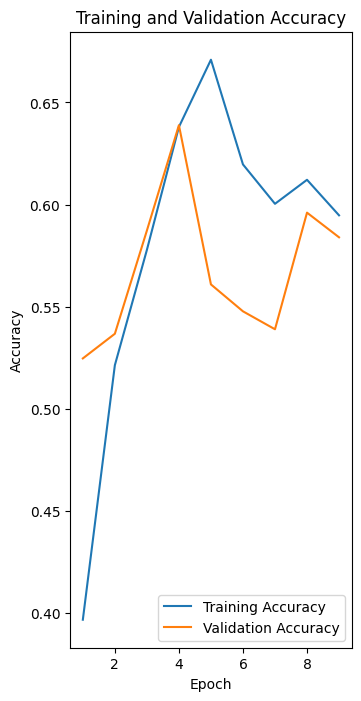

In [53]:
import matplotlib.pyplot as plt

epochs_range = range(1, 10)
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

# Plotting the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


### Testing on specific images

PIL image size (224, 224)


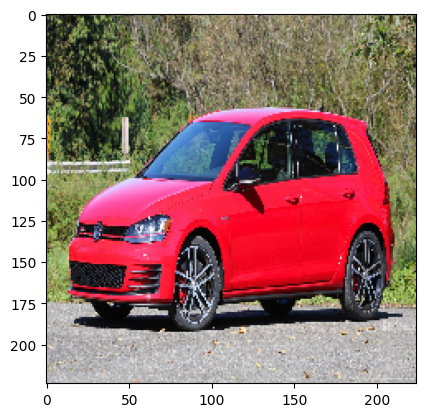

In [22]:
filename = '/content/2017-volkswagen-golf-gti-sport-review.jpg'
## load an image in PIL format
original = load_img(filename, target_size = (224, 224))
print('PIL image size',original.size)
plt.imshow(original)
plt.show()

In [23]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis = 0)
processed_image = kb.applications.vgg16.preprocess_input(image_batch.copy())
prediction = custom_ff.predict(processed_image)
prediction

1/1 [==============================] - 1s 558ms/step


array([[0.0000000e+00, 0.0000000e+00, 4.1054363e-21, 3.0512549e-03,
        0.0000000e+00, 1.3922638e-25, 9.9694878e-01]], dtype=float32)

In [24]:
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Sedan with a 31.10 percent confidence.


#### Inorrect, should be hatchback



---



PIL image size (224, 224)


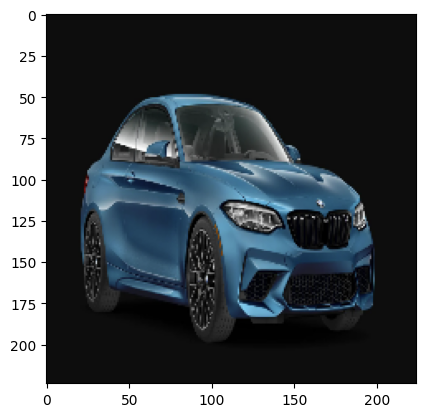

In [31]:
filename = '/content/M2Comp.png'
## load an image in PIL format
original = load_img(filename, target_size = (224, 224))
print('PIL image size',original.size)
plt.imshow(original)

plt.show()

In [32]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis = 0)
processed_image = kb.applications.vgg16.preprocess_input(image_batch.copy())
prediction = custom_ff.predict(processed_image)
prediction

1/1 [==============================] - 0s 23ms/step


array([[0.0000000e+00, 9.7142286e-12, 3.4525107e-07, 1.1055670e-05,
        9.6299384e-31, 3.9104661e-12, 9.9998856e-01]], dtype=float32)

In [33]:
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Sedan with a 31.18 percent confidence.


#### Incorrect, should be coupe



---



PIL image size (224, 224)


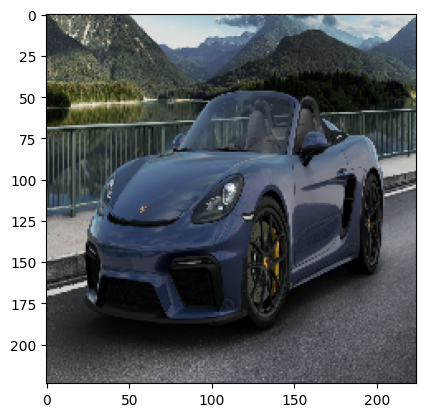

In [28]:
filename = '/content/718_spyder_gentianblue.png'
## load an image in PIL format
original = load_img(filename, target_size = (224, 224))
print('PIL image size',original.size)
plt.imshow(original)

plt.show()

In [29]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis = 0)
processed_image = kb.applications.vgg16.preprocess_input(image_batch.copy())
prediction = custom_ff.predict(processed_image)
prediction

1/1 [==============================] - 0s 22ms/step


array([[1.5100426e-36, 9.9955863e-01, 2.2609885e-05, 1.1085506e-07,
        2.1817499e-27, 1.0477587e-18, 4.1862830e-04]], dtype=float32)

In [30]:
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Convertible with a 31.17 percent confidence.


#### Correct



---



PIL image size (224, 224)


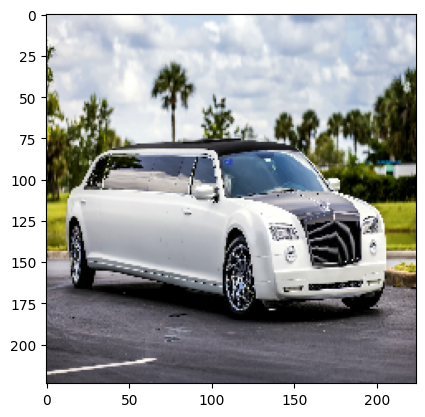

In [34]:
filename = '/vip-limo-service-rolls-royce-phantom-300-exterior-01-1500.jpg'
## load an image in PIL format
original = load_img(filename, target_size = (224, 224))
print('PIL image size',original.size)
plt.imshow(original)

plt.show()

In [35]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis = 0)
processed_image = kb.applications.vgg16.preprocess_input(image_batch.copy())
prediction = custom_ff.predict(processed_image)
prediction

1/1 [==============================] - 0s 23ms/step


array([[0.00000000e+00, 3.41825010e-17, 1.09245857e-18, 8.57516169e-20,
        1.00000000e+00, 5.34539805e-36, 1.06228255e-17]], dtype=float32)

In [36]:
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Limousine with a 31.18 percent confidence.


Correct



---



PIL image size (224, 224)


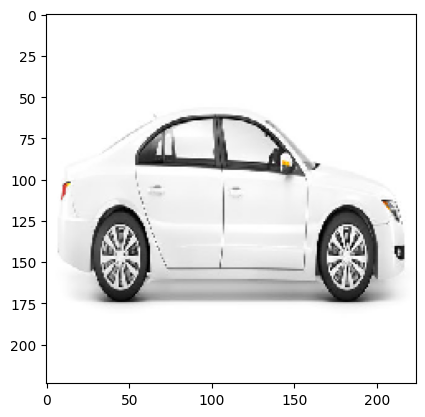

In [37]:
filename = '/content/white_sedan.jpg'
## load an image in PIL format
original = load_img(filename, target_size = (224, 224))
print('PIL image size',original.size)
plt.imshow(original)

plt.show()

In [38]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis = 0)
processed_image = kb.applications.vgg16.preprocess_input(image_batch.copy())
prediction = custom_ff.predict(processed_image)
prediction

1/1 [==============================] - 0s 23ms/step


array([[1.4305062e-35, 4.7230851e-30, 1.2762921e-17, 3.4832805e-01,
        1.0311244e-30, 3.6774009e-01, 2.8393182e-01]], dtype=float32)

In [39]:
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Minivan with a 17.64 percent confidence.


Incorrect, should be Sedan



---



PIL image size (224, 224)


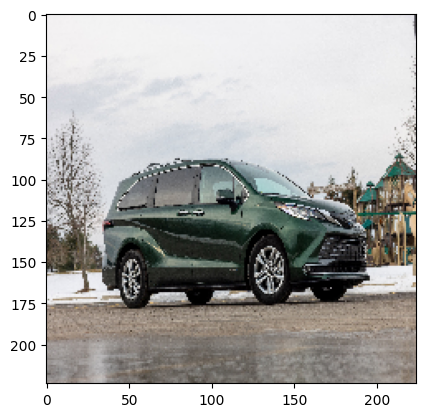

In [40]:
filename = '/content/2021-toyota-sienna-limited-awd-15k-update-118-1653069638.jpg'
## load an image in PIL format
original = load_img(filename, target_size = (224, 224))
print('PIL image size',original.size)
plt.imshow(original)

plt.show()

In [41]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis = 0)
processed_image = kb.applications.vgg16.preprocess_input(image_batch.copy())
prediction = custom_ff.predict(processed_image)
prediction

1/1 [==============================] - 0s 23ms/step


array([[0.0000000e+00, 1.0223242e-04, 2.4870648e-12, 5.9874505e-09,
        7.7344580e-20, 9.9984670e-01, 5.0957125e-05]], dtype=float32)

In [42]:
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Minivan with a 31.18 percent confidence.


Correct



---



PIL image size (224, 224)


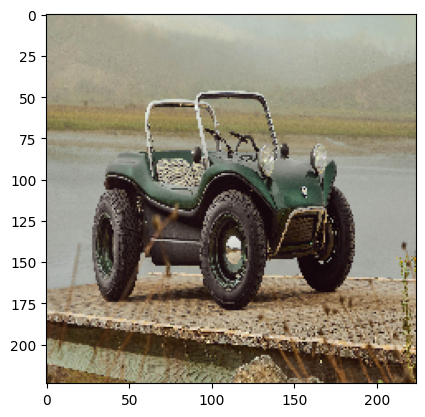

In [54]:
filename = '/content/2S6A9130.jpg'
## load an image in PIL format
original = load_img(filename, target_size = (224, 224))
print('PIL image size',original.size)
plt.imshow(original)

plt.show()

In [55]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis = 0)
processed_image = kb.applications.vgg16.preprocess_input(image_batch.copy())
prediction = custom_ff.predict(processed_image)
prediction

1/1 [==============================] - 0s 179ms/step


array([[1.000000e+00, 2.622348e-36, 2.489550e-37, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00]], dtype=float32)

In [56]:
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Buggy with a 31.18 percent confidence.


Correct